MÉTRIQUES :

https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2


Classification binaire, 2 classes, positive et negative. 
- Acc : (TP+TN)/(TP+TN+FP+FN) -- Quelle proportion des samples (pos et neg) sont correctement classifiés ?
- Precision : TP / (TP + FP) -- Quelle proportion des prédictions positives sont réellement positives ?
- Recall : TP / (TP + FN) -- Quelle proportion des positives sont correctement classifiées ? 

Multi-class classification, 1 à N classes. On calcule métrique pour chaque classe. Comment agréger métrique en une valeur ?
- Macro-averaged (macro) : moyenne
- Weighted : moyenne pondérée par le nombre de samples dans chaque classe 



- Top-k accuracy : la classe correcte se trouve dans le top-k des images les plus similaires 
- Top-k precision
- Top-k recall



TODO :
- Relancer les entrainements avec les data aug 

Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
DRIVE_PATH = "/content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images"

In [6]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import tensorflow as tf

In [7]:
import os
import random
import itertools
import typing

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Lambda, Dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize

In [51]:
import pickle 

def load_pickle(filename, dir):
    completeName = os.path.join(f"{dir}/{filename}")
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data

def save_as_pickle(filename, dir, data):
    completeName = os.path.join(f"{dir}/{filename}")
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)

## LFW dataset

### Loading

In [8]:
%%capture

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xvzf lfw-deepfunneled.tgz

In [9]:
PATH = "lfw-deepfunneled/"
USE_SUBSET = False

In [10]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = np.random.choice(dirs, 500, False)

name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print("Number of classes: ", num_classes)

Number of classes:  5749


In [11]:
# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)} 
id_to_path = {v: k for k, v in path_to_id.items()}

In [12]:
# build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}

### Exploration

Nombre d'images par classe

In [ ]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53)]

Nombre de classes avec $n$ images

In [ ]:
# Combien de classes avec 1 ou 2 images ?
# num_images : nb de classes qui ont un nb d'images 'num_images'
from collections import defaultdict

num_classes_with_num_images = defaultdict(int)
for k, v in list(classid_to_ids.items()):
    num_classes_with_num_images[len(v)] += 1

In [ ]:
list(num_classes_with_num_images.items())[:10]

[(1, 4069),
 (4, 187),
 (2, 779),
 (19, 7),
 (3, 291),
 (12, 10),
 (5, 112),
 (8, 33),
 (7, 39),
 (6, 55)]

Images du dataset

In [ ]:
img = imread(id_to_path[0]) # Numpy
print(f"Image shape: {img.shape}")
#print(f"Pixels' value in [0, 255]")

Image shape: (250, 250, 3)


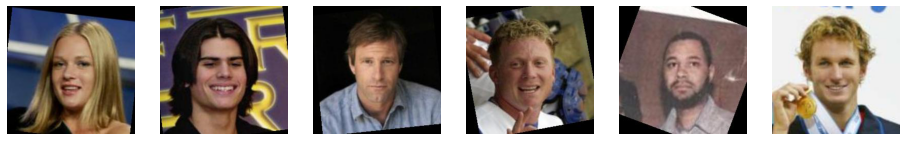

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    img = imread(id_to_path[classid_to_ids[i][0]]) 
    plt.imshow(img)
    plt.axis('off')

Les images sont bien centrées sur les visages. On remarque toutefois que certaines présentent des bordures noires car les images ont été pivotées pour que le visage représenté soit centré. Est-ce que ces bordures noires impacteront l'entraînement du modèle ? 


### Preprocessing


On souhaite entraîner un réseau siamois, qui prend en entrée deux images $x_1$ et $x_2$ et donne en sortie une valeur représentant la similarité entre ces deux images.

On construit donc des ensembles de paires positives et négatives.

In [13]:
# Build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    
    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [14]:
# Build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)
    
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)
        
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
        
    return neg_pairs

La fonction suivante crée des ensembles de paires positives/négatives, qui constitueront nos jeux d'entraînement, de validation et de test. Plus précisemment, elle renvoie des arrays d'IDs que nous utiliserons par la suite dans un générateur (afin d'éviter de conserver les images ouvertes en mémoire).

Dans chaque jeu de données, il y a 50% de paires positives et 50% de paires négatives.

On sépare le jeu de données de la manière suivante : 60/20/20 (train, validation, test).

Classes représentées dans :
- Train : 0 à num_classes * 0.6
- Val : num_classes * 0.6 à num_classes * 0.8
- Test : num_classes * 0.8 à num_classes-1

In [15]:
# 50%/50% positive and negative pairs in each set
def build_train_val_test_data(train_ratio=0.6, val_ratio=0.2):
    listX1 = []
    listX2 = []
    listY = []
    #perm_classes = np.random.permutation(num_classes)
    range_classes = range(num_classes)
    train_classes = range_classes[:int(num_classes * train_ratio)]
    val_classes = range_classes[int(num_classes * train_ratio):int(num_classes * (train_ratio + val_ratio))]
    test_classes = range_classes[int(num_classes * (train_ratio + val_ratio)):]

    #train_split = int(num_classes * train_ratio)
    #val_split = int(num_classes * (train_ratio + val_ratio))
    #split = int(num_classes * split)
    #print(f"split={split}")
    
    # train : on le construit avec les images de class_id de 0 a split
    for class_id in train_classes:
        pos = build_pos_pairs_for_id(class_id)
        neg = build_neg_pairs_for_id(class_id, list(train_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.RandomState(seed=42).permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    # Validation set
    for id in val_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(val_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_val = np.array(listX1)
    X2_ids_val = np.array(listX2)
    Y_ids_val = np.array(listY)

    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in test_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(test_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    
    return (X1_ids_train, X2_ids_train, Y_ids_train, train_classes,
            X1_ids_val, X2_ids_val, Y_ids_val, val_classes,
            X1_ids_test, X2_ids_test, Y_ids_test, test_classes)

In [16]:
X1_ids_train, X2_ids_train, train_Y, train_classes, X1_ids_val, X2_ids_val, val_Y, val_classes, X1_ids_test, X2_ids_test, test_Y, test_classes = build_train_val_test_data()

In [17]:
X1_ids_train.shape, X2_ids_train.shape, train_Y.shape

((18336,), (18336,), (18336,))

In [18]:
X1_ids_val.shape, X2_ids_val.shape, val_Y.shape

((5700,), (5700,), (5700,))

In [19]:
X1_ids_test.shape, X2_ids_test.shape, test_Y.shape

((6410,), (6410,), (6410,))

Générateur

In [20]:
from skimage.io import imread
from skimage.transform import resize


def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(path)), 0)]
    return np.vstack(all_imgs)

In [21]:
all_imgs = open_all_images(id_to_path)
all_imgs.shape

(13233, 60, 60, 3)

In [ ]:
str(all_imgs.nbytes / 1e6) + "MB"

'1143.3312MB'

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(
        0.3,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    # You can add more transformation like random rotations, random change of luminance, etc.
])

In [ ]:
feed_shape = (3, 60, 60)
training = True

In [32]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs, training=False):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        self.training = training
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        
        imgs1 = self.imgs[self.X1[low_index:high_index]]
        imgs2 = self.imgs[self.X2[low_index:high_index]]

        if training:
            imgs1 = seq.augment_images(imgs1)
            imgs2 = seq.augment_images(imgs2)
            
        targets = self.Y[low_index:high_index]
    
        return ([imgs1, imgs2], targets)

In [ ]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs, training=True)

In [ ]:
print("Number of batches: {}".format(len(gen)))

Number of batches: 573


In [ ]:
[x1, x2], y = gen[0]

x1.shape, x2.shape, y.shape

((32, 60, 60, 3), (32, 60, 60, 3), (32,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

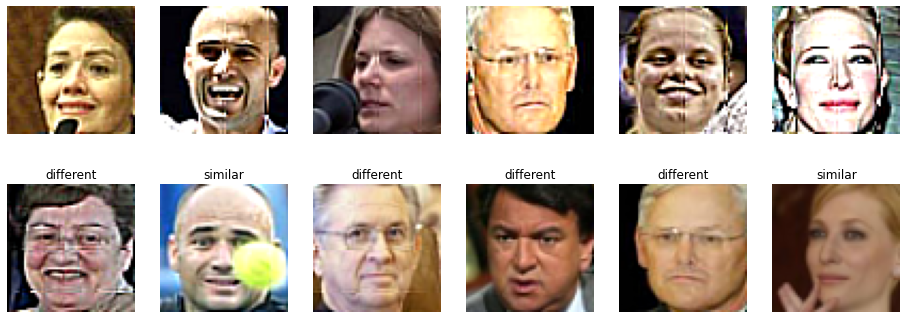

In [ ]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')
    
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
    
plt.show()

### Test classification set

In [ ]:
# One image id for each class
imgs_ids_db = [classid_to_ids[class_id][0] for class_id in range(num_classes)]

In [ ]:
imgs_ids_db[:10]

[0, 1, 2, 3, 4, 5, 9, 10, 12, 13]

## Classifieur

In [33]:
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, "float32")
    return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                  (1 - y_true) * tf.square(tf.maximum(y_pred - margin, 0)))

In [34]:
@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.

    Accuracy of the ability of the network to differentiate two people.
    '''
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

In [35]:
def evaluate(model):
    pass

### Baseline

Generator

In [36]:
train_gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs, training=True)
#val_gen = Generator(X1_ids_val, X2_ids_val, val_Y, feed_shape=(3, 60, 60), training=False)

In [37]:
val_X1 = all_imgs[X1_ids_val]
val_X2 = all_imgs[X2_ids_val]

In [38]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

Model

In [39]:
# Define a configuration for your experiments
class ModelConfig(typing.NamedTuple):
    conv_layers: typing.List
    dense_layers: typing.List
    use_pool: bool
    use_dropout: bool

In [40]:
class SharedConv(tf.keras.Model):
    def __init__(self, config):
        super().__init__(self, name="sharedconv")

        self.config = config

        self.conv_layers = []
        for filters, kernel_size, stride in config.conv_layers:
            self.conv_layers.append(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), activation='relu'))

        self.dense_layers = []
        for units, activation in config.dense_layers:
            self.dense_layers.append(Dense(units=units, activation=activation))

        self.flatten = Flatten()
        
    def call(self, x):

        for conv in self.conv_layers:
            x = conv(x)
            if self.config.use_pool:
                x = MaxPool2D((2, 2))(x)

        x = self.flatten(x)

        for dense in self.dense_layers:
            if self.config.use_dropout:
                x = Dropout(0.5)(x)
            x = dense(x)

        return x

In [41]:
class Siamese(tf.keras.Model):
    def __init__(self, shared_conv):
        super().__init__(self, name="siamese")
        self.shared_conv = shared_conv
        self.dot = Dot(normalize=True, axes=1)
        
    def call(self, inputs):
        out1 = self.shared_conv(inputs[0]) # [bs=32, out_dim=50]
        out2 = self.shared_conv(inputs[1])
        dot = self.dot([out1, out2])
        
        return dot

In [42]:
def create_siamese_model(config):
    shared_conv = SharedConv(config)
    model = Siamese(shared_conv)
    model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy_sim])
    return model

Training


###### Config 1

In [ ]:
config1 = ModelConfig(
    conv_layers=[(128, 8, 4), (64, 4, 2), (8, 4, 1)],
    dense_layers=[(50, "sigmoid")],
    use_pool = False,
    use_dropout = False
)

config2 = ModelConfig(
    conv_layers=[(128, 4, 1), (64, 4, 1), (32, 4, 1)],
    dense_layers=[(50, "sigmoid")],
    use_pool = True,
    use_dropout = True
)

In [ ]:
model = create_siamese_model(config1)

In [ ]:
num_model = 1
best_model_fname = f"{DRIVE_PATH}/models/baseline_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=5) # Stop the training when no improv in val_loss for 5 epochs

In [ ]:
history = model.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

In [ ]:
save_as_pickle("baseline_1.pkl", DRIVE_PATH+"/history", history)

INFO:tensorflow:Assets written to: ram://303f5d25-7cef-4f2a-94c3-0420a90ae52b/assets


In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()

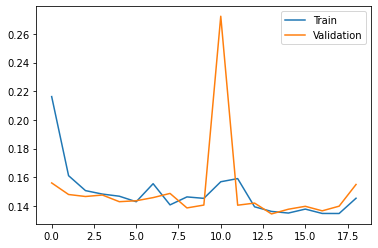

In [ ]:
plot_history(history)

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 1s 6ms/step - loss: 0.1543 - accuracy_sim: 0.5023
Test loss: 0.15432758629322052
Test (binary) classification accuracy based on similarity: 0.5023009777069092


Pas très bon résultat, pour le moment, le réseau prédit toujours la même chose, que pour deux images donnés, ce sont les mêmes personnes, et donc c'est pour ça qu'on a une acc_sim de 0.5...

Accuracy of face identification task

Multi-class classification

In [ ]:
img1 = test_X1[0]
img2 = test_X2[0]
y_true = test_Y[0]

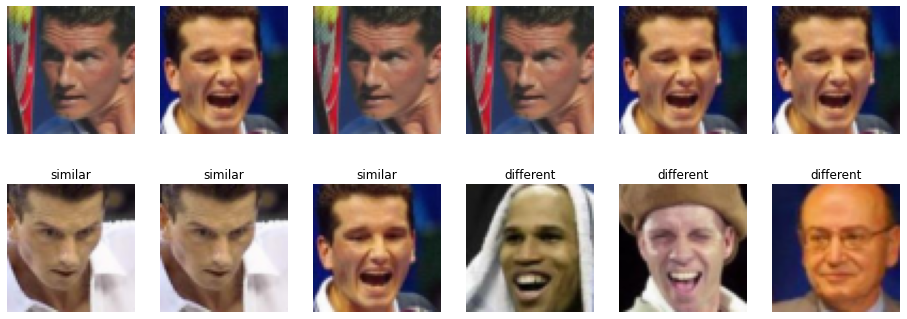

In [ ]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(test_X1[i] / 255)
    plt.axis('off')
    
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(test_X2[i] / 255)
    if test_Y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
    
plt.show()

In [ ]:
y_pred = model.predict(x=(test_X1[:6], test_X2[:6]))

In [ ]:
y_pred

array([[0.7002065 ],
       [0.6149187 ],
       [0.67082   ],
       [0.74999946],
       [0.8603088 ],
       [0.6308931 ]], dtype=float32)

In [ ]:
y_true = test_Y[:6]
y_true

array([1, 1, 1, 0, 0, 0])

In [ ]:
accuracy_sim(tf.cast(y_true, "float32"), y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
#baseline = create_siamese_model(config)
#baseline.load_weights(latest)

##### Config 2

In [ ]:
baseline2 = create_siamese_model(config2)

In [ ]:
num_model = 2
best_model_fname = f"{DRIVE_PATH}/models/baseline_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=5) # Stop the training when no improv in val_loss for 5 epochs

In [ ]:
history2 = baseline2.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

Epoch 1/50
572/573 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy_sim: 0.5003
Epoch 1: val_accuracy_sim improved from -inf to 0.49756, saving model to /content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images/models/baseline_2.ckpt
573/573 [==============================] - 28s 47ms/step - loss: 0.1612 - accuracy_sim: 0.5004 - val_loss: 0.2633 - val_accuracy_sim: 0.4976
Epoch 2/50
571/573 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy_sim: 0.4995
Epoch 2: val_accuracy_sim did not improve from 0.49756
573/573 [==============================] - 21s 37ms/step - loss: 0.1762 - accuracy_sim: 0.4997 - val_loss: 0.2764 - val_accuracy_sim: 0.4976
Epoch 3/50
571/573 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy_sim: 0.4998
Epoch 3: val_accuracy_sim did not improve from 0.49756
573/573 [==============================] - 15s 27ms/step - loss: 0.1747 - accuracy_sim: 0.4999 - val_loss: 0.2638 - val_accuracy_sim: 0.4976
Epoch 4/50
5

In [ ]:
save_as_pickle("baseline_2.pkl", DRIVE_PATH+"/history", history2)

INFO:tensorflow:Assets written to: ram://8eb65e9e-5497-47e5-b897-88d44364ce5a/assets


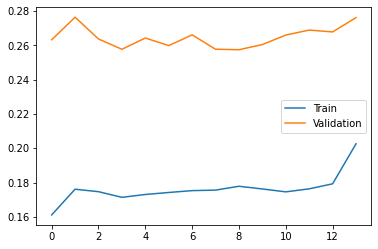

In [ ]:
plot_history(history2)

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = baseline2.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 2s 9ms/step - loss: 0.2758 - accuracy_sim: 0.4997
Test loss: 0.27575382590293884
Test (binary) classification accuracy based on similarity: 0.4996579587459564


### Pre-trained

VGG16 : entraîné sur plus de 14 million d'images en haute résolution appartenant à 1000 classes différentes.

In [22]:
from keras.applications.vgg16 import VGG16

In [23]:
from keras.applications.vgg16 import preprocess_input

On souhaite récupérer les couches de convolution du VGG16 pré-entraîné, pas la partie classifieur. Autrement dit, on souhaite utiliser les caractéristiques que le modèle a réussi à trouver.

Intégrer ces couches en tant que shared_conv du modèle siamois.

- include_top=False pour enlever les couches de classificaton
- Set the model as not trainable

In [26]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(60, 60, 3))
vgg16.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
class SharedConvPretrained(tf.keras.Model):
    def __init__(self, config, backbone):
        super().__init__(self, name="sharedconvpretrained")

        self.config = config
        self.backbone = backbone
        self.flatten = Flatten()
        self.dense_layers = [Dense(units, activation=activation) for units, activation in config.dense_layers]
        
    def call(self, x):

        x = self.backbone(x)
        x = self.flatten(x)
        for dense in self.dense_layers:
            if self.config.use_dropout:
                x = Dropout(0.5)(x)
            x = dense(x)
        return x

In [27]:
def create_pretrained_siamese_model(config, backbone=vgg16):
    shared_conv = SharedConvPretrained(config, backbone)
    model = Siamese(shared_conv)
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy_sim])
    return model

In [43]:
config1 = ModelConfig(
    conv_layers=[],
    dense_layers=[(100, "relu"), (50, "sigmoid")],
    use_pool = False,
    use_dropout = True
)

config2 = ModelConfig(
    conv_layers=[],
    dense_layers=[(300, "relu"), (100, "relu"), (50, "sigmoid")],
    use_pool = False,
    use_dropout = True
)

In [44]:
pretrained_model = create_pretrained_siamese_model(config1)
pretrained_model.load_weights(f"{DRIVE_PATH}/models/pretrained_1.ckpt")

In [ ]:
num_model = 1
best_model_fname = f"{DRIVE_PATH}/models/pretrained_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=10) # Stop the training when no improv in val_loss for 5 epochs

In [ ]:
# 20 min
history = pretrained_model.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

Epoch 1/50
573/573 [==============================] - ETA: 0s - loss: 0.1442 - accuracy_sim: 0.5032
Epoch 1: val_accuracy_sim improved from -inf to 0.49948, saving model to /content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images/models/pretrained_1.ckpt
573/573 [==============================] - 28s 47ms/step - loss: 0.1442 - accuracy_sim: 0.5032 - val_loss: 0.1501 - val_accuracy_sim: 0.4995
Epoch 2/50
572/573 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy_sim: 0.5085
Epoch 2: val_accuracy_sim improved from 0.49948 to 0.50419, saving model to /content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images/models/pretrained_1.ckpt
573/573 [==============================] - 30s 53ms/step - loss: 0.1419 - accuracy_sim: 0.5084 - val_loss: 0.1514 - val_accuracy_sim: 0.5042
Epoch 3/50
572/573 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy_sim: 0.5185
Epoch 3: val_accuracy_sim improved from 0.50419 to 0.52409, saving model to /content/gdrive/MyDrive/D

In [ ]:
save_as_pickle("pretrained_1.pkl", DRIVE_PATH+"/history", history)

INFO:tensorflow:Assets written to: ram://41aa9e42-8ada-4373-9e80-5e71142b472b/assets


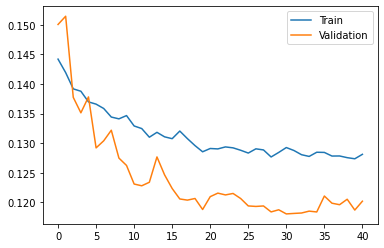

In [ ]:
plot_history(history)

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = pretrained_model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 19s 35ms/step - loss: 0.1206 - accuracy_sim: 0.5967
Test loss: 0.12062393128871918
Test (binary) classification accuracy based on similarity: 0.5967040061950684


Multi-class classificaton results:

Classification binaire, 2 classes, positive et negative. 
- Acc : (TP+TN)/(TP+TN+FP+FN) -- Quelle proportion des samples (pos et neg) sont correctement classifiés ?
- Precision : TP / (TP + FP) -- Quelle proportion des prédictions positives sont réellement positives ?
- Recall : TP / (TP + FN) -- Quelle proportion des positives sont correctement classifiées ? 

Multi-class classification, 1 à N classes. On calcule métrique pour chaque classe. 
- Precision : 

Comment agréger métrique en une valeur ?
- Macro-averaged (macro) : moyenne
- Weighted : moyenne pondérée par le nombre de samples dans chaque classe 



- Top-k accuracy : la classe correcte se trouve dans le top-k des images les plus similaires 
- Top-k precision
- Top-k recall




Alors ici on veut evaluer notre classifieur sur le test set : 
- `test_classes=1150` classes, dont **334 classes avec plus d'une image**
- `all_img_test_idx=2468` images, dont **1171 images qui correspondent aux classes avec plus d'une image**
- `testclass_to_imgids`: à chaque test class avec plus d'une image, on associe les ids des images de la classe correspondante

In [45]:
# Gather the ids of all images that are used for train and test
all_img_train_idx = list(set(X1_ids_train) | set(X2_ids_train))
all_img_val_idx = list(set(X1_ids_val) | set(X2_ids_val))
all_img_test_idx = list(set(X1_ids_test) | set(X2_ids_test))

In [46]:
test_ids = []
for class_id in test_classes:
    img_ids = classid_to_ids[class_id]
    if len(img_ids) > 1:
        test_ids += img_ids

In [107]:
len(test_ids)

1771

In [47]:
testclass_to_imgids = {class_id: classid_to_ids[class_id] for class_id in test_classes if len(classid_to_ids[class_id]) > 1}

In [105]:
list(testclass_to_imgids.items())[0]

(4601, [10648, 10649, 10650])

(array([318.,   9.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2. ,  16.2,  30.4,  44.6,  58.8,  73. ,  87.2, 101.4, 115.6,
        129.8, 144. ]),
 <a list of 10 Patch objects>)

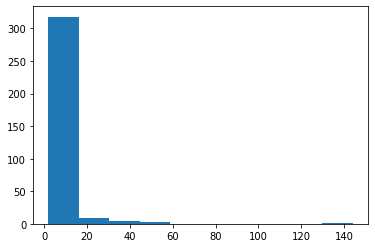

In [106]:
plt.hist([len(v) for v in testclass_to_imgids.values()])

In [63]:
true_num_test_classes = len(list(testclass_to_imgids.keys()))

In [103]:
print(f"{len(list(test_classes))} test classes, {len(list(testclass_to_imgids.keys()))} classes with > 1 image.")
print(f"{len(all_img_test_idx)} test images, {sum([len(v) for v in testclass_to_imgids.values()])} images corresponding to classes with > 1 image.")

1150 test classes, 334 classes with > 1 image.
2468 test images, 1771 images corresponding to classes with > 1 image.


Il faudra boucler sur les 1771 images

Calcul de metrique pour 334 classes ?



Par exemple, si je veux calculer métrique pour la class_id = 4601, qui a 3 images :
- précision : nombre de predictions correctes (TP) (ici entre 0 et 3 puisqu'il y a 3 images) / nombre total de predictions pour 4601
- recall : nombre de predictions correctes (TP) / nombre total de photos de 4601, donc 3 ici 


Ici on suppose que le modele donne une seule prédiction (on peut recuperer le top-1)





- Accuracy@k : nombre de fois ou le label correct est dans les k labels predits (ici les k classes les plus similaires à l'image en question)
    - Limite : unbalanced dataset
  
Seulement pour precision et recall :
- Macro https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
    - Average (balanced acc dans le latex) : moyenne des métrique de chaque classe, chaque classe contribue identiquement au calcul de la metrique meme si proportion differente dans le dataset
    - Weighted = moyenne ponderee par contribution de chaque classe (nombre relatif d'examples de chaque classe)
- Micro : 
    - recall (somme des TP de chaque classe / somme des TP et FN de chaque classe)

In [52]:
#emb = pretrained_model.shared_conv.predict(all_imgs)
#emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)
emb = load_pickle("pretrained_1_emb.pkl", f"{DRIVE_PATH}/models")
pixelwise = np.reshape(all_imgs, (all_imgs.shape[0], 60*60*3))

In [56]:
def most_sim(idx, topn=5, mode="cosine"):
    x = emb[idx]
    if mode == "cosine":
        x = x / np.linalg.norm(x)
        sims = np.dot(emb, x)
        ids = np.argsort(sims)[::-1]
        return [(id, sims[id]) for id in ids[:topn]]
    elif mode == "euclidean":
        dists = np.linalg.norm(emb - x, axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]
    else:
        dists = np.linalg.norm(pixelwise - pixelwise[idx], axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]

In [57]:
def accuracy_k(k=10, mode="embedding"):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = []
        if mode == "embedding":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1)[1:]]
        elif mode == "random":
            found_classes = [id_to_classid[x] for x in random.sample(
                list(set(all_img_test_idx + all_img_val_idx + all_img_train_idx) - {img_idx}), k)]
        elif mode == "image":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1, mode="image")[1:]]
        
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)

In [58]:
modes = ["embedding", "random"]
k_vals = [1, 5, 10]

for mode in modes:
    print(f'----- {mode} -----')
    for k in k_vals:
        print(f'k={k} -- {accuracy_k(k, mode)}')

----- embedding -----
k=1 -- 0.02258610954263128
k=5 -- 0.06945228684359118
k=10 -- 0.09937888198757763
----- random -----
k=1 -- 0.0016939582156973462
k=5 -- 0.00564652738565782
k=10 -- 0.01355166572557877




```
----- embedding -----
k=1 -- 0.02258610954263128
k=5 -- 0.06945228684359118
k=10 -- 0.09937888198757763

----- random -----
k=1 -- 0.0016939582156973462
k=5 -- 0.009599096555618294
k=10 -- 0.01637492941840768
```



In [64]:
test_ids[:10]

[10648, 10649, 10650, 10655, 10656, 10657, 10658, 10659, 10660, 10661]

In [66]:
list(testclass_to_imgids.items())[0]

(4601, [10648, 10649, 10650])

In [ ]:
def accuracy_k(k=10, mode="embedding"):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = []
        if mode == "embedding":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1)[1:]]
        elif mode == "random":
            found_classes = [id_to_classid[x] for x in random.sample(
                list(set(all_img_test_idx + all_img_val_idx + all_img_train_idx) - {img_idx}), k)]
        elif mode == "image":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1, mode="image")[1:]]
        
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)

In [90]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(mode="embedding"):
    # Compute y_pred = estimated targets 
    y_pred = []
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        if mode == "embedding":
            x = most_sim(img_idx, topn=2)[1:][0][0] # [1:] pour ne pas prendre l'image elle meme
        elif mode == "random":
            x = random.sample(list(set(all_img_test_idx + all_img_val_idx + all_img_train_idx) - {img_idx}), 1)
        predicted_class = id_to_classid[x]
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)

    # Compute y_true = ground truth (correct) target values
    y_true = np.array([id_to_classid[x] for x in test_ids])

    # List of labels to index the matrix
    labels = list(testclass_to_imgids.keys())
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    
    return conf_matrix


In [94]:
def predict_ground_truth(mode="embedding"):
    
    # Compute y_pred = estimated targets 
    y_pred = []
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        if mode == "embedding":
            x = most_sim(img_idx, topn=2)[1:][0][0] # [1:] pour ne pas prendre l'image elle meme
        elif mode == "random":
            x = random.sample(list(set(all_img_test_idx + all_img_val_idx + all_img_train_idx) - {img_idx}), 1)
        predicted_class = id_to_classid[x]
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)

    return y_pred

In [96]:
y_pred = predict_ground_truth() # (1771, )
y_true = np.array([id_to_classid[x] for x in test_ids]) # (1771, )
labels = list(testclass_to_imgids.keys()) # labels que pour les classes avec > 1 image

In [98]:
from sklearn.metrics import precision_score, recall_score

average_modes=["macro", "weighted", "micro"]
def get_evaluation_metrics(y_pred, y_true, labels, average_modes):
    scores = {}
    for average_mode in average_modes:
        scores[f'{average_mode}-recall'] = recall_score(y_true, y_pred, labels)
        scores[f'{average_mode}-precision'] = precision_score(y_true, y_pred, labels)
    return scores

In [ ]:
scores = get_evaluation_metrics(y_pred, y_true, labels)
scores

In [85]:
img_idx = 10650
classid = id_to_classid[img_idx]
k=5
found_classes = most_sim(img_idx, topn=2)[1:][0][0]
found_classes, classid

(1733, 4601)

(1733, 4601)

In [59]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [78]:
my_dot = Dot(normalize=True, axes=1)

def most_sim2(x, emb, topn=5):
    x_e = tf.expand_dims(x, axis=0)
    
    best_candidates_with_scores = list()
    
    for i, candidate in enumerate(emb):
        c_e = tf.expand_dims(candidate, axis=0)
        sim = float(my_dot([x_e, c_e]))
        
        best_candidates_with_scores.append((i, sim))
        best_candidates_with_scores = sorted(best_candidates_with_scores, key=lambda s: s[1])[-topn:]
        
    return best_candidates_with_scores

query: Richard_Krajicek 10650
nearest matches
Tim_Henman 12167 0.9647786021232605


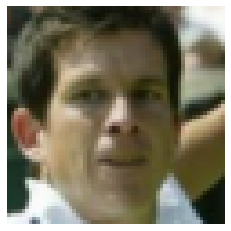

Colin_Powell 2247 0.9652083516120911


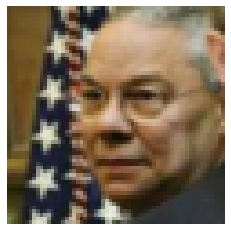

Andreas_Vinciguerra 579 0.9657827615737915


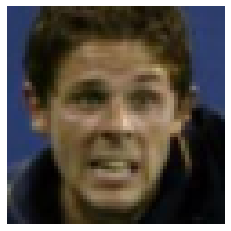

Carlos_Quintanilla_Schmidt 1733 0.981916606426239


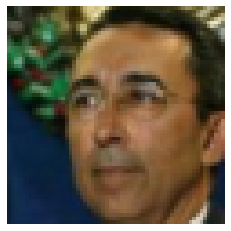

Richard_Krajicek 10650 1.0000001192092896


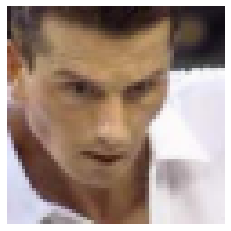

In [79]:
interesting_classes = list(filter(lambda x: len(x[1]) > 4, classid_to_ids.items()))
#class_id = random.choice(interesting_classes)[0]
class_id = id_to_classid[test_ids[0]]

query_id = random.choice(classid_to_ids[class_id])
print("query:", classid_to_name[class_id], query_id)
# display(all_imgs[query_id])

print("nearest matches")
for result_id, sim in most_sim2(emb[query_id], emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)    
    display(all_imgs[result_id])

## Attaques adverses

- FGSM
- BIM
- Accuracies and adversarial accuracies